In [1]:
# Import dependencies
import os
import click
import pandas as pd
import numpy as np
from dwave.system import LeapHybridCQMSampler, LeapHybridSampler
from dimod import ConstrainedQuadraticModel, BinaryQuadraticModel, QuadraticModel, quicksum, Binary, Integer
from dotenv import load_dotenv, find_dotenv
import pprint
import matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

In [2]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [3]:
# Set the relative weight for the different type of costs
weight_machines = 0.8
weight_products = 0.2

In [4]:
# Define the sets
P = ["P1", "P2", "P3"]
M = ["CNC", "Mill", "Drill", "Punch"]
S = ["R", "S"]
N = M + S

# Define the routing information
routing = {
    "P1": ["R", "CNC", "Drill", "Punch", "S"],
    "P2": ["R", "Mill", "Drill", "Punch", "S"],
    "P3": ["R", "CNC", "Drill", "Mill", "Punch", "S"]
}

# Define the machine coordinates
machine_coords = {
    "CNC": (100, 200),
    "Mill": (300, 100),
    "Drill": (200, 100),
    "Punch": (100, 300)
}

# Define the receiving and shipping point coordinates
receiving_coord = (500, 125)
shipping_coord = (715, 450)


# Minimum distance between different machines
machine_distances = {
    ('CNC', 'Mill'): 50,
    ('CNC', 'Drill'): 50,
    ('CNC', 'Punch'): 50
}

# Cost of moving machine per distance unit
machine_move_costs = {
    'CNC': 300,
    'Mill': 300,
    'Drill': 300,
    'Punch': 300
}

# Cost of moving product per distance unit
product_move_costs = {
    'P1': 100,
    'P2': 100,
    'P3': 100
}

# Define machine bounds (R and S as well)
machine_bounds = {'CNC': (155, 300, 100, 300),
                  'Mill': (100, 228, 100, 300),
                  'Drill': (100, 300, 100, 300),
                  'Punch': (221, 300, 100, 293),
                  'R': (500, 500, 125, 125),
                  'S': (715, 715, 450, 450),
                  }

In [5]:
def refactor_routing(routing):
    """
    Refactor the initial_routing dictionary into a format where each product is associated with a list of tuples.

    Args:
        routing (dict): The initial routing dictionary.

    Returns:
        dict: The refactored routing dictionary.

        Examples:
        >>> initial_routing = {'P1': ['R', 'CNC', 'Drill', 'Punch', 'S'],
                              'P2': ['R', 'Mill', 'Drill', 'Punch', 'S'],
                              'P3': ['R', 'CNC', 'Drill', 'Mill', 'Punch', 'S']}
                              
        >>> refactor_routing(initial_routing)
        Output: {'P1': [('R', 'CNC'), ('CNC', 'Drill'), ('Drill', 'Punch'), ('Punch', 'S')],
                 'P2': [('R', 'Mill'), ('Mill', 'Drill'), ('Drill', 'Punch'), ('Punch', 'S')],
                 'P3': [('R', 'CNC'), ('CNC', 'Drill'), ('Drill', 'Mill'), ('Mill', 'Punch'), ('Punch', 'S')]}

    """
    refactored_routing = {}
    for p, centers in routing.items():
        refactored_centers = [(centers[i], centers[i+1]) for i in range(len(centers) - 1)]
        refactored_routing[p] = refactored_centers

    return refactored_routing

In [6]:
def build_cqm(weight_machines = weight_machines, weight_products = weight_products ):

    """
    Build a Constrained Quadratic Model (CQM) based on the provided parameters.

    Args:
        weight_machines (float): Weight coefficient for machine move costs.
        weight_products (float): Weight coefficient for product move costs.

    Returns:
        ConstrainedQuadraticModel: The constructed Constrained Quadratic Model.

    """
    
    # Refactor the initial_routing dictionary in a format where each product is associated with a list of tuples
    refactored_routing = refactor_routing(routing)
    
    # Creates the initial dictionary z with all possible key-value pairs set to 0, with key-value pairs with swapped n1 and n2
    z = {(p, n1, n2): 0 for p in P for n1 in N for n2 in N if n1 != n2} | {(p, n2, n1): 0 for p in P for n1 in N for n2 in N if n1 != n2} 
    # Update the dictionary z with values based on the routing information
    z.update({(p, n1, n2): 1 for p in P for n1, n2 in refactored_routing[p]})

    
    # Define integer variables for each machine's x coordinate (R and S included)
    xm = {m: Integer('x_{}'.format(m), lower_bound=machine_bounds[m][0], upper_bound=machine_bounds[m][1]) for m in N}
    
    # Define integer variables for each machine's y coordinate (R and S included)
    ym = {m: Integer('y_{}'.format(m), lower_bound=machine_bounds[m][2], upper_bound=machine_bounds[m][3]) for m in N}

    # Define the initial points of the machines (R and S included)
    x0 = {n: machine_coords[n][0] if n in M else (receiving_coord[0] if n == 'R' else receiving_coord[1]) for n in N}
    y0 = {n: machine_coords[n][1] if n in M else (shipping_coord[0] if n == 'R' else shipping_coord[1]) for n in N}

    # Instantiate the Constrained Quadratic Model
    cqm = ConstrainedQuadraticModel()

    # Calculate the cost of moving the machines
    cost_m = quicksum([weight_machines * machine_move_costs[m] * ((xm[m] - x0[m]) ** 2 + (ym[m] - y0[m]) ** 2) for m in M])

    # Calculate the cost of moving the products 
    cost_p = quicksum([weight_products * product_move_costs[p] * z[p, n1, n2] * ((xm[n1] - xm[n2]) ** 2 + (ym[n1] - ym[n2]) ** 2)
                  for p in P for n1 in N for n2 in N if n1 != n2])
    
    #Calculate the total cost
    cost = cost_m + cost_p

    #Set the objective:  to minimize the total costs
    cqm.set_objective(cost)

    # Add constraint to maintain the minimum distance between the machines
    constraints = [(xm[m1] - xm[m2]) ** 2 + (ym[m1] - ym[m2]) ** 2 >= machine_distances[(m1, m2)] ** 2
                for m1 in M for m2 in M if m1 != m2 and (m1, m2) in machine_distances]

    # Add the constraints to the Constrained Quadratic Model
    [cqm.add_constraint(constraint) for constraint in constraints]

    return cqm

In [7]:
def parse_result(cqm):

    """
    Parse the result of a Constrained Quadratic Model (CQM) optimization.

    Args:
        cqm (ConstrainedQuadraticModel): The optimized Constrained Quadratic Model.

    Returns:
        dict: The parsed result containing machine coordinates.

    """

    # Solve the problem
    sampler = LeapHybridCQMSampler(token=token)
    print("Submitting CQM to solver {}.".format(sampler.solver.name))
    # Sample from the model
    sampleset = sampler.sample_cqm(cqm, label='Layout Optimization')
    feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
    if not len(feasible_sampleset):
        raise ValueError("No feasible solution found")

    # Get the lowest feasible energy solution and store the solution variable
    best = feasible_sampleset.first

    # format the response
    result = {}
    for key, value in best.sample.items():
        machine = key[2:]
        coord_type = key[0]
        if machine not in result:
            result[machine] = {}
        result[machine][coord_type] = value
    
    return result

In [8]:
def costs(result):

    """
    Calculate the total cost of moving the machines based on the result.

    Args:
        result (dict): The result containing machine optimized coordinates.

    Returns:
        float: The total cost of moving the machines and the products

    """

    # Refactor the initial_routing dictionary in a format where each product is associated with a list of tuples
    refactored_routing = refactor_routing(routing)
    
    # Calculate the distance between each machine's original coordinates and its new coordinates
    machine_distances = {}
    for machine in machine_coords:
        orig_coords = machine_coords[machine]
        new_coords = result[machine]
        machine_distances[machine] = ((orig_coords[0] - new_coords['x']) ** 2 + (orig_coords[1] - new_coords['y']) ** 2) ** 0.5

    # Calculate the total cost of moving the machines
    total_machine_move_cost = 0
    for machine, distance in machine_distances.items():
        if machine in machine_move_costs:
            cost_per_unit = machine_move_costs[machine]
        else:
            cost_per_unit = 0
        total_machine_move_cost += distance * cost_per_unit

    print(f"Total cost of moving the machines is: {total_machine_move_cost}")

    # Calculate the total cost of moving the products
    product_costs = {}
    for product, route in refactored_routing.items():
        product_cost = 0
        for i in range(len(route)):
            source_machine, target_machine = route[i]
            source_coord = result[source_machine]
            target_coord = result[target_machine] if target_machine != 'S' else result['S']
            distance = ((target_coord['x'] - source_coord['x']) ** 2 + (target_coord['y'] - source_coord['y']) ** 2) ** 0.5
            product_cost += distance
        product_costs[product] = product_cost
    total_product_move_cost = sum([value * product_move_costs[key] for key, value in product_costs.items()])
    print(f"Total cost of moving the products is: {total_product_move_cost}")

    # Calculate the total costs   
    
    total_cost = total_machine_move_cost +total_product_move_cost
    formatted_cost = '\nTotal cost of changes is : {:,.0f}'.format(total_cost)

    return print(formatted_cost)


In [9]:
def plot_graph(optimized_coords):

    """
    Plots the initial and optimized positions of machines along with receiving and shipping points.

    Args:
        optimized_coords (list): List of tuples containing machine names and their optimized coordinates.

    Returns:
        None
    """
# Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the initial positions on the left subplot
    ax1.set_title('Initial Positions')
    for name, coords in machine_coords.items():
        ax1.scatter(coords[0], coords[1], color='red')
        ax1.annotate(name, coords)

    # Plot the initial and optimized positions on the right subplot
    ax2.set_title('Initial and Optimized Positions')
    for name, coords in machine_coords.items():
        ax2.scatter(coords[0], coords[1], color='red', alpha=0.25)  # Set the transparency of the initial points
        ax2.annotate(name, coords)

    for machine, x, y in optimized_coords:
        ax2.scatter(x, y, color='blue')
        ax2.annotate(machine, (x, y))

    # Plot the receiving and shipping points in both subplots
    for ax in [ax1, ax2]:
        ax.scatter(receiving_coord[0], receiving_coord[1], color='green', marker='s', s=100)
        ax.scatter(shipping_coord[0], shipping_coord[1], color='yellow', marker='s', s=100)
        ax.annotate('R', receiving_coord, ha='center', va='center', fontsize=10)
        ax.annotate('S', shipping_coord, ha='center', va='center', fontsize=10)

    # Set the axis limits and labels for both subplots
    for ax in [ax1, ax2]:
        ax.set_xlim(0, 800)
        ax.set_ylim(0, 500)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # Add a legend with correct colors
    ax2.legend(labels=['Initial Positions', 'Optimized Positions', 'Receiving (S)', 'Shipping (R)'],
            handles=[
                plt.Line2D([0], [0], marker='o', color='red', label='Initial Positions', linestyle='None'),
                plt.Line2D([0], [0], marker='o', color='blue', label='Optimized Positions', linestyle='None'),
                plt.Line2D([0], [0], marker='s', color='green', label='Receiving (R)', linestyle='None'),
                plt.Line2D([0], [0], marker='s', color='yellow', label='Shipping (S)', linestyle='None')
            ])

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # Save the figure
    plt.savefig('machine_positions.png')

    # Show the plot
    plt.show()

In [10]:
cqm = build_cqm()

In [11]:
result = parse_result(cqm)

Submitting CQM to solver hybrid_constrained_quadratic_model_version1.


In [12]:
costs(result)

Total cost of moving the machines is: 88186.30455362593
Total cost of moving the products is: 319412.82029645576

Total cost of changes is : 407,599


In [13]:
optimized_coords = [(machine, result[machine]['x'], result[machine]['y']) for machine in result if machine != 'R' and machine != 'S']
print ('\nOptimized coordinates:')
for machine, x, y in optimized_coords:
    print(f"{machine}: ({x}, {y})")


Optimized coordinates:
CNC: (163.0, 182.0)
Drill: (201.0, 133.0)
Mill: (228.0, 118.0)
Punch: (221.0, 293.0)


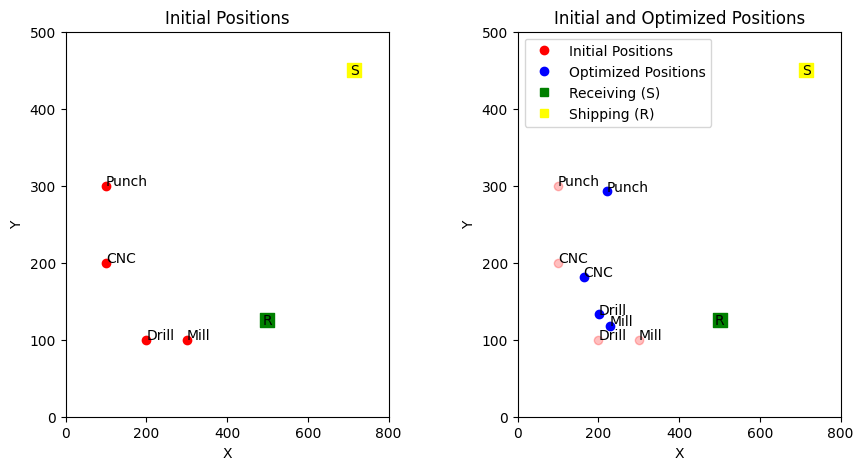

In [14]:
plot_graph(optimized_coords)